In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("/workspaces/MambaLinearCode")
os.chdir("/workspaces/MambaLinearCode")


In [3]:
from configuration import Code, Config
from dataset import get_generator_and_parity
import torch
import os
import logging

def code_from_hint(hint,):
    code_files = os.listdir(CODES_PATH)
    code_files = [f for f in code_files if hint in f][0]
    print(code_files)
    code_n = int(code_files.split('_')[1][1:])
    code_k = int(code_files.split('_')[-1][1:].split('.')[0])
    code_type = code_files.split('_')[0]
    code = Code(code_n, code_k, code_type)
    return code

OUTPUT_PATH = ".output/"
CODES_PATH = "codes/"
example_code = code_from_hint("LDPC_N49_K24")
G,H = get_generator_and_parity(example_code, standard_form=True)
example_code.generator_matrix = torch.from_numpy(G).transpose(0,1).long()
example_code.pc_matrix = torch.from_numpy(H).long()

os.makedirs(OUTPUT_PATH, exist_ok=True)
config = Config(
    code=example_code,
    d_model=32,
    d_state=64,
    path=OUTPUT_PATH,
    N_dec=8,
    warmup_lr=1.0e-4,
    lr=1.0e-4,
    epochs=1000
)

handlers = [
        logging.FileHandler(os.path.join(OUTPUT_PATH, 'logging.txt')),
        logging.StreamHandler()
    ]
logging.basicConfig(level=logging.INFO, format='%(message)s',
                    handlers=handlers)

LDPC_N49_K24.alist


In [5]:
from mamba_ssm import Mamba
from dataset import EbN0_to_std, ECC_Dataset, train, test, sign_to_bin
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.nn import ModuleList, LayerNorm
import copy

device = "cuda"

def clones(module, N):
    return ModuleList([copy.deepcopy(module) for _ in range(N)])

def build_mask(code):
    mask_size = code.n + code.pc_matrix.size(0)
    mask = torch.eye(mask_size, mask_size)
    for ii in range(code.pc_matrix.size(0)):
        idx = torch.where(code.pc_matrix[ii] > 0)[0]
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    mask[jj, kk] += 1
                    mask[kk, jj] += 1
                    mask[code.n + ii, jj] += 1
                    mask[jj, code.n + ii] += 1
    src_mask = (mask > 0)
    return src_mask

class EncoderLayer(torch.nn.Module):
    def __init__(self, config: Config, length) -> None:
        super().__init__()
        self.mamba = Mamba(
            d_model=config.d_model,
            d_state=config.d_state
        )
        self.norm = LayerNorm((length, config.d_model))
        self.n = config.code.n
        self.pc_checks = config.code.pc_matrix.size(0)
        self.register_buffer('pc_mask', build_mask(config.code))
        self.in_resize = torch.nn.Linear(config.d_model, self.n+self.pc_checks)
        self.in_reset_size = torch.nn.Linear(self.n + self.pc_checks, config.d_model)
        self.out_resize = torch.nn.Linear(config.d_model, self.n+self.pc_checks)
        self.out_reset_size = torch.nn.Linear(self.n + self.pc_checks, config.d_model)
    
    def forward(self, x):
        h = self.in_resize(x)
        h = h * self.pc_mask[0,0]
        h = self.in_reset_size(h)
        h *= x
        o1 = self.mamba.forward(h)
        o2 = torch.flip(self.mamba.forward(torch.flip(h,[1])),[1])
        o = o1+o2
        o = self.out_resize(o)
        o = o * self.pc_mask
        o = self.out_reset_size(o)
        o *= x
        return self.norm(F.tanh(x))

class ECCM(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.n = config.code.n
        self.pc_checks = config.code.pc_matrix.size(0)
        self.src_embed = torch.nn.Parameter(torch.ones(
            (self.n + self.pc_checks, config.d_model)))
        self.resize_output_dim = torch.nn.Linear(config.d_model, 1)
        self.resize_output_length = torch.nn.Linear(self.n + self.pc_checks, self.n)
        self.norm_output = LayerNorm((self.n,))
        
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)
        
        self.mamba: ModuleList = clones(EncoderLayer(config, (self.n + self.pc_checks)), config.N_dec)
    
    def forward(self, magnitude, syndrome):
        emb = torch.cat([magnitude, syndrome], -1).unsqueeze(-1)
        out: torch.Tensor = self.src_embed.unsqueeze(0) * emb
        for sublayer in self.mamba:
            out: torch.Tensor = sublayer.forward(out) # self.n+self.syndrom_length, d_model
        
        out: torch.Tensor = self.resize_output_length(out.swapaxes(-2,-1))
        out: torch.Tensor = self.resize_output_dim(out.swapaxes(-2,-1))
        out: torch.Tensor = out.squeeze(-1)
        return self.norm_output(F.tanh(out))

    def loss(self, z_pred, z2, y):
        loss = F.binary_cross_entropy_with_logits(
            z_pred, sign_to_bin(torch.sign(z2)))
        x_pred = sign_to_bin(torch.sign(-z_pred * torch.sign(y)))
        return loss, x_pred
model = ECCM(config=config).to("cuda")

In [4]:
def train_model(args: Config, model: torch.nn.Module):
    code = args.code
    initial_lr = args.warmup_lr
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = Adam(model.parameters(), lr=args.warmup_lr)

    # model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
    # optimizer.load_state_dict(torch.load(os.path.join(config.path, 'optimizer_checkpoint')))
    

    #################################
    EbNo_range_test = range(4, 7)
    EbNo_range_train = range(2, 8)
    std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    train_dataloader = DataLoader(ECC_Dataset(code, std_train, len=args.batch_size * 1000, zero_cw=True), batch_size=int(args.batch_size),
                                  shuffle=True, num_workers=args.workers)
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(args.test_batch_size), zero_cw=False),
                                       batch_size=int(args.test_batch_size), shuffle=False, num_workers=args.workers) for ii in range(len(std_test))]
    #################################

    best_loss = float('inf')
    # for epoch in range(1,3):
    #     loss, ber, fer = train(model, device, train_dataloader, optimizer,
    #                            epoch, LR=initial_lr, config=args)
    #     if loss < best_loss:
    #         best_loss = loss
    #         torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
    
    scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=args.eta_min)
    # scheduler.load_state_dict(torch.load(os.path.join(config.path, 'scheduler_checkpoint')))

    for epoch in range(1, args.epochs + 1):
        loss, ber, fer = train(model, device, train_dataloader, optimizer,
                               epoch, LR=scheduler.get_last_lr()[0], config=args)
        scheduler.step()
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
            torch.save(optimizer.state_dict(), os.path.join(args.path, 'optimizer_checkpoint'))
            torch.save(scheduler.state_dict(), os.path.join(args.path, 'scheduler_checkpoint'))

        # if epoch % 200 == 0:
        #     test(model, device, test_dataloader_list, EbNo_range_test)
    return model

train_model(config, model)

Training: 100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]
Epoch 1 Train Time 73.93021821975708s

Training: 100%|██████████| 1000/1000 [01:13<00:00, 13.63it/s]
Epoch 2 Train Time 73.36011147499084s

Training: 100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]
Epoch 3 Train Time 74.08665418624878s

Training: 100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]
Epoch 4 Train Time 72.53195118904114s

Training: 100%|██████████| 1000/1000 [01:06<00:00, 15.02it/s]
Epoch 5 Train Time 66.57089686393738s

Training: 100%|██████████| 1000/1000 [01:05<00:00, 15.25it/s]
Epoch 6 Train Time 65.55916333198547s

Training: 100%|██████████| 1000/1000 [01:05<00:00, 15.27it/s]
Epoch 7 Train Time 65.47681021690369s

Training: 100%|██████████| 1000/1000 [01:06<00:00, 15.12it/s]
Epoch 8 Train Time 66.13916540145874s

Training: 100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]
Epoch 9 Train Time 66.53188252449036s

Training: 100%|██████████| 1000/1000 [01:07<00:00, 14.79it/s]
Epoch 10 Train Time 67.599689

In [7]:
import time
from dataset import bin_to_sign, BER, FER
from tqdm import tqdm
import numpy as np

def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
    model.eval()
    t = time.time()
    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            test_loss = test_ber = test_fer = cum_count = 0.
            for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                z_mul = -(y * bin_to_sign(x))
                z_pred = model(magnitude.to(device), syndrome.to(device))
                loss, x_pred = model.loss(-z_pred, z_mul.to(device), y.to(device))

                test_loss += loss.item()

                test_ber += BER(x_pred, x.to(device))
                test_fer += FER(x_pred, x.to(device))
            ln_ber = -np.log(test_ber)
            logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} -ln(BER)={ln_ber:.2e}')

def _test(config, model):
    EbNo_range_test = range(0, 11)
    code = config.code
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(config.test_batch_size), zero_cw=False),
                                        batch_size=int(config.test_batch_size), shuffle=False, num_workers=config.workers) for ii in range(len(std_test))]
    test(model, 'cuda', test_dataloader_list, EbNo_range_test)
model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
_test(config, model)

/tmp/ipykernel_808/1964912410.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
Testing: 100%|█

In [8]:

model = ECCM(config=config)
model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
model = model.to("cuda")

/tmp/ipykernel_808/2858039931.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))


In [36]:
from dataset import bin_to_sign

code = config.code
EbNo_range_train = [5]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
z_mul = (y * bin_to_sign(x))
if len(z_mul.shape) < 2:
    z_mul = z_mul.unsqueeze(0)
z_pred = model(mag.to('cuda'), syn.to('cuda'))
print(z_pred.shape, z_mul.shape)
loss, x_pred = model.loss(-z_pred, z_mul.to('cuda'), y.to('cuda'))
mag, syn, z_pred, z_mul, loss, x_pred

torch.Size([1, 49]) torch.Size([1, 49])


(tensor([0.4088, 0.8753, 1.1154, 1.1782, 0.5120, 1.5581, 0.5942, 0.6546, 0.6640,
         0.0324, 0.9378, 0.6654, 0.7365, 0.6614, 0.6114, 1.6320, 2.6217, 0.7731,
         0.8895, 1.2220, 0.5241, 1.4081, 0.8772, 1.9551, 0.1367, 0.6679, 1.0144,
         1.2929, 0.6523, 0.7113, 1.0940, 2.1230, 0.1073, 1.2876, 1.2061, 0.5629,
         0.5588, 1.1120, 1.2857, 0.3438, 0.8440, 0.9382, 0.5116, 0.9380, 0.0501,
         0.4033, 0.5285, 0.7348, 2.0556]),
 tensor([ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.]),
 tensor([[ 7.1580,  7.5678,  6.7079,  6.5955,  6.2516,  6.8364,  7.2832,  7.2998,
           7.9689, -4.8371,  7.5992,  7.2584,  7.8876,  7.3152,  6.2642,  8.1351,
           7.6308,  7.9487,  7.3857,  9.6573,  6.0551,  6.5745,  7.4570,  7.5394,
           5.6933,  7.3272,  6.6034,  7.3792,  6.2857,  7.4604,  6.4929,  7.7946,
           6.8777,  7.3587,  6.8430,  7.1945,  6.5008,  6.7291, 

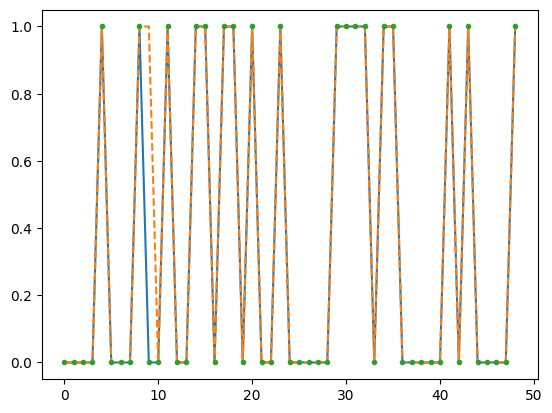

In [37]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(x)
plt.plot(y<0, '--')
plt.plot(x_pred[0].detach().cpu().numpy(), ". ")

In [32]:
# Ideas:
# Bi-directional
# Load and output